# 第8章: ニューラルネット

# 70. 単語ベクトルの和による特徴量

In [1]:
import gensim
import numpy as np
import pandas as pd

train = pd.read_csv('./NewsAggregatorDataset/train.txt', sep='\t', names=['CATEGORY', 'TITLE'])
valid = pd.read_csv('./NewsAggregatorDataset/valid.txt', sep='\t', names=['CATEGORY', 'TITLE'])
test = pd.read_csv('./NewsAggregatorDataset/test.txt', sep='\t', names=['CATEGORY', 'TITLE'])

In [2]:
# 学習済み単語ベクトルファイルのロード
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [3]:
import string
import torch

def transform_w2v(text):
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    words = text.translate(table).split()  # 記号をスペースに置換後、スペースで分割してリスト化
    vec = [model[word] for word in words if word in model]  # 1語ずつベクトル化

    return torch.tensor(sum(vec) / len(vec))  # 平均ベクトルをTensor型に変換して出力

# 特徴ベクトルの作成
X_train = torch.stack([transform_w2v(text) for text in train['TITLE']])
X_valid = torch.stack([transform_w2v(text) for text in valid['TITLE']])
X_test = torch.stack([transform_w2v(text) for text in test['TITLE']])

print(X_train.size())
print(X_train)

torch.Size([10672, 300])
tensor([[ 0.0930,  0.1105, -0.0617,  ...,  0.0472,  0.1016,  0.1064],
        [ 0.0773,  0.1216, -0.0084,  ...,  0.0125,  0.0744,  0.0549],
        [ 0.0144, -0.0348,  0.0461,  ...,  0.0654,  0.0590, -0.0838],
        ...,
        [-0.0356,  0.1175,  0.1018,  ..., -0.0172,  0.0627,  0.0960],
        [ 0.0226,  0.0159, -0.0263,  ...,  0.0301,  0.1126, -0.1359],
        [-0.0124, -0.0050, -0.0422,  ..., -0.0068,  0.1063, -0.0074]])


In [4]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category_dict[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category_dict[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category_dict[x]).values)

print(y_train.size())
print(y_train)

torch.Size([10672])
tensor([2, 0, 0,  ..., 0, 0, 2])


In [5]:
# 保存
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(y_train, 'y_train.pt')
torch.save(y_valid, 'y_valid.pt')
torch.save(y_test, 'y_test.pt')

# 71. 単層ニューラルネットワークによる予測

In [6]:
from torch import nn

# 単層ニューラルネットワークの定義
class SLPNet(nn.Module):
    # ネットワークを構成するレイヤーの定義
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size, bias=False)
        nn.init.normal_(self.fc.weight, 0.0, 1.0)  # 正規乱数で重みを初期化

    # インプットデータが順伝播時に通るレイヤーを順に配置
    def forward(self, x):
        x = self.fc(x)
        return x


model = SLPNet(300, 4)  # 単層ニューラルネットワークの初期化
y_hat_1 = torch.softmax(model(X_train[:1]), dim=-1)
print(y_hat_1)

tensor([[0.6096, 0.0510, 0.1385, 0.2008]], grad_fn=<SoftmaxBackward0>)


In [7]:
Y_hat = torch.softmax(model.forward(X_train[:4]), dim=-1)
print(Y_hat)

tensor([[0.6096, 0.0510, 0.1385, 0.2008],
        [0.3334, 0.2882, 0.3065, 0.0719],
        [0.1507, 0.4539, 0.1839, 0.2115],
        [0.2838, 0.3863, 0.1461, 0.1838]], grad_fn=<SoftmaxBackward0>)


# 72. 損失と勾配の計算

In [8]:
criterion = nn.CrossEntropyLoss()

In [9]:
# 学習データの事例x1に対してクロスエントロピー損失と行列Wに対する勾配を計算
l_1 = criterion(model(X_train[:1]), y_train[:1])  # 入力ベクトルはsoftmax前の値
model.zero_grad()  # 勾配をゼロで初期化
l_1.backward()  # 勾配を計算
print(f'損失: {l_1:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 1.9768
勾配:
tensor([[ 0.0567,  0.0673, -0.0376,  ...,  0.0287,  0.0619,  0.0648],
        [ 0.0047,  0.0056, -0.0031,  ...,  0.0024,  0.0052,  0.0054],
        [-0.0801, -0.0952,  0.0532,  ..., -0.0406, -0.0875, -0.0916],
        [ 0.0187,  0.0222, -0.0124,  ...,  0.0095,  0.0204,  0.0214]])


In [10]:
# 事例集合x1, x2, x3, x4に対してクロスエントロピー損失と行列Wに対する勾配を計算
l = criterion(model(X_train[:4]), y_train[:4])
model.zero_grad()
l.backward()
print(f'損失: {l:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 1.7228
勾配:
tensor([[-0.0040,  0.0061, -0.0202,  ..., -0.0093, -0.0074,  0.0290],
        [ 0.0054,  0.0092,  0.0005,  ...,  0.0082,  0.0161,  0.0015],
        [-0.0068, -0.0226,  0.0221,  ..., -0.0046, -0.0195, -0.0351],
        [ 0.0054,  0.0073, -0.0024,  ...,  0.0057,  0.0109,  0.0046]])


# 73. 確率的勾配降下法による学習

`Dataset`:特徴ベクトルとラベルベクトルを合わせて保持することができる型  
`Dataloader`:Datasetを入力とし，指定したサイズにまとめたデータを順に取り出すことができる．

In [11]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, X, y):  # datasetの構成要素を指定
        self.X = X
        self.y = y
        
    def __len__(self):  # len(dataset)で返す値を指定
        return len(self.y)
    
    def __getitem__(self, idx):  # dataset[idx]で返す値を指定
        return [self.X[idx], self.y[idx]]

In [12]:
from torch.utils.data import DataLoader

# Datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

# Dataloaderの作成
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

行列Wを学習する．  
計算した勾配から重みも更新するため，オプティマイザも定義する．  
エポック数を10として学習を実行する．

In [13]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10
for epoch in range(num_epochs):
    # 訓練モードに設定
    model.train()
    loss_train = 0.0
    for i, (inputs, labels) in enumerate(dataloader_train):
        # 勾配をゼロで初期化
        optimizer.zero_grad()

        # 順伝播 + 誤差逆伝播 + 重み更新
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 損失を記録
        loss_train += loss.item()
        
    # バッチ単位の平均損失計算
    loss_train = loss_train / i
    
    # 検証データの損失計算
    model.eval() 
    with torch.no_grad():
        inputs, labels = next(iter(dataloader_valid))
        outputs = model(inputs)
        loss_valid = criterion(outputs, labels)
        
    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')  

epoch: 1, loss_train: 0.4816, loss_valid: 0.3859
epoch: 2, loss_train: 0.3230, loss_valid: 0.3398
epoch: 3, loss_train: 0.2912, loss_valid: 0.3250
epoch: 4, loss_train: 0.2747, loss_valid: 0.3107
epoch: 5, loss_train: 0.2639, loss_valid: 0.3144
epoch: 6, loss_train: 0.2563, loss_valid: 0.2997
epoch: 7, loss_train: 0.2496, loss_valid: 0.3057
epoch: 8, loss_train: 0.2446, loss_valid: 0.2997
epoch: 9, loss_train: 0.2416, loss_valid: 0.2976
epoch: 10, loss_train: 0.2381, loss_valid: 0.3008


# 74. 正解率の計測

In [14]:
def calculate_accuracy(model, loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

    return correct / total

In [15]:
acc_train = calculate_accuracy(model, dataloader_train)
acc_test = calculate_accuracy(model, dataloader_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.918
正解率（評価データ）：0.900


# 75. 損失と正解率のプロット

In [16]:
# 前問74.　のcalculate_accuracyを，損失も計算できるように改変
def calculate_loss_and_accuracy(model, criterion, loader):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()
    
    return loss / len(loader), correct / total

`calculate_loss_and_accuracy`をエポックごとに適用することで損失と正解率を記録する．

In [20]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 30
log_train = []
log_valid = []

for epoch in range(num_epochs):
    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
        
        # 勾配をゼロで初期化
        optimizer.zero_grad()

        # 順伝播 + 誤差逆伝播 + 重み更新
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')

epoch: 1, loss_train: 0.3335, accuracy_train: 0.8831, loss_valid: 0.3656, accuracy_valid: 0.8688
epoch: 2, loss_train: 0.2878, accuracy_train: 0.9009, loss_valid: 0.3302, accuracy_valid: 0.8876
epoch: 3, loss_train: 0.2687, accuracy_train: 0.9062, loss_valid: 0.3153, accuracy_valid: 0.8943
epoch: 4, loss_train: 0.2600, accuracy_train: 0.9089, loss_valid: 0.3130, accuracy_valid: 0.9018
epoch: 5, loss_train: 0.2511, accuracy_train: 0.9135, loss_valid: 0.3059, accuracy_valid: 0.8996
epoch: 6, loss_train: 0.2408, accuracy_train: 0.9172, loss_valid: 0.2996, accuracy_valid: 0.9018
epoch: 7, loss_train: 0.2379, accuracy_train: 0.9187, loss_valid: 0.2986, accuracy_valid: 0.8988
epoch: 8, loss_train: 0.2328, accuracy_train: 0.9195, loss_valid: 0.2965, accuracy_valid: 0.9010
epoch: 9, loss_train: 0.2305, accuracy_train: 0.9219, loss_valid: 0.2976, accuracy_valid: 0.8973
epoch: 10, loss_train: 0.2274, accuracy_train: 0.9214, loss_valid: 0.2979, accuracy_valid: 0.8996
epoch: 11, loss_train: 0.2273

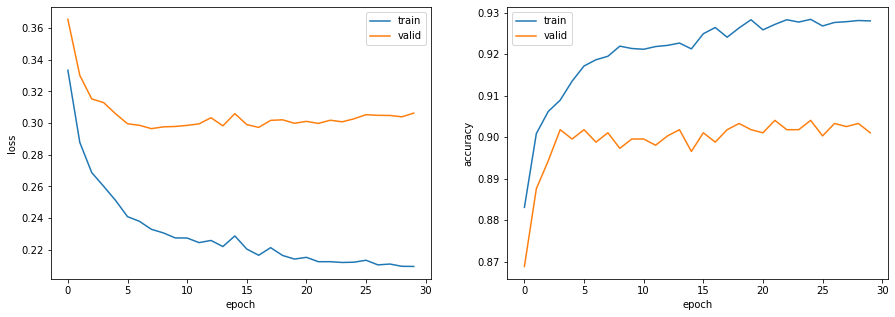

In [21]:
from matplotlib import pyplot as plt

#プロット
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

# 76. チェックポイント

学習途中のパラメータは`model.state_dict()`，最適化アルゴリズムの内部状態は`optimizer.state_dict()`でアクセス可能．

In [23]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 30
log_train = []
log_valid = []

for epoch in range(num_epochs):
    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
        
        # 勾配をゼロで初期化
        optimizer.zero_grad()

        # 順伝播 + 誤差逆伝播 + 重み更新
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントのファイル書き出し
    # エポック，学習途中のパラメータ，最適化アルゴリズムの内部状態
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')

epoch: 1, loss_train: 0.3280, accuracy_train: 0.8843, loss_valid: 0.3688, accuracy_valid: 0.8786
epoch: 2, loss_train: 0.2868, accuracy_train: 0.9000, loss_valid: 0.3346, accuracy_valid: 0.8958
epoch: 3, loss_train: 0.2673, accuracy_train: 0.9075, loss_valid: 0.3167, accuracy_valid: 0.8951
epoch: 4, loss_train: 0.2572, accuracy_train: 0.9090, loss_valid: 0.3120, accuracy_valid: 0.8981
epoch: 5, loss_train: 0.2467, accuracy_train: 0.9162, loss_valid: 0.3034, accuracy_valid: 0.8981
epoch: 6, loss_train: 0.2444, accuracy_train: 0.9172, loss_valid: 0.3044, accuracy_valid: 0.8943
epoch: 7, loss_train: 0.2402, accuracy_train: 0.9166, loss_valid: 0.3028, accuracy_valid: 0.9010
epoch: 8, loss_train: 0.2352, accuracy_train: 0.9209, loss_valid: 0.2996, accuracy_valid: 0.8966
epoch: 9, loss_train: 0.2299, accuracy_train: 0.9214, loss_valid: 0.3003, accuracy_valid: 0.8966
epoch: 10, loss_train: 0.2273, accuracy_train: 0.9234, loss_valid: 0.2963, accuracy_valid: 0.8973
epoch: 11, loss_train: 0.2246

# 77. ミニバッチ化

B事例ごとに損失・勾配を計算し，行列Wの値を更新する．  
Bの値を1, 2, 4, 8, ...と変化させ1エポックの学習に要する時間を比較する．

In [29]:
import time

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs):
    # dataloaderの作成
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
    
    # 学習
    log_train = []
    log_valid = []
    for epoch in range(num_epochs):
        # 開始時刻の記録
        s_time = time.time()
        # 訓練モードに設定
        model.train()
        for inputs, labels in dataloader_train:
            # 勾配をゼロで初期化
            optimizer.zero_grad()
            # 順伝播 + 誤差逆伝播 + 重み更新
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # 損失と正解率の算出
        loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
        loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        # チェックポイントの保存
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        # 終了時刻の記録
        e_time = time.time()

        # ログを出力
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    return {'train': log_train, 'valid': log_valid}


In [31]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
    print(f'バッチサイズ: {batch_size}')
    log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1)

バッチサイズ: 1
epoch: 1, loss_train: 0.3334, accuracy_train: 0.8817, loss_valid: 0.3655, accuracy_valid: 0.8763, 4.5199sec
バッチサイズ: 2
epoch: 1, loss_train: 0.3040, accuracy_train: 0.8960, loss_valid: 0.3347, accuracy_valid: 0.8846, 2.4908sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2953, accuracy_train: 0.8984, loss_valid: 0.3283, accuracy_valid: 0.8921, 1.4922sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2907, accuracy_train: 0.8991, loss_valid: 0.3245, accuracy_valid: 0.8898, 0.8113sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2889, accuracy_train: 0.8994, loss_valid: 0.3229, accuracy_valid: 0.8906, 0.4917sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2879, accuracy_train: 0.9000, loss_valid: 0.3221, accuracy_valid: 0.8898, 0.3247sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2874, accuracy_train: 0.9004, loss_valid: 0.3218, accuracy_valid: 0.8906, 0.2281sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2873, accuracy_train: 0.9007, loss_valid: 0.3216, accuracy_valid: 0.8906, 0.1964sec
バッチサイズ: 256
epoch: 1, loss_train: 0.2880, accuracy_

# 78. GPU上での学習

In [34]:
# 75..　のcalculate_loss_and_accuracyにGPUを指定する引数'device'を追加
def calculate_loss_and_accuracy_2(model, criterion, loader, device):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()
    
    return loss / len(loader), correct / total

In [37]:
def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
    # GPUに送る
    model.to(device)
    
    # dataloaderの作成
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
    
    # 学習
    log_train = []
    log_valid = []
    
    for epoch in range(num_epochs):
        s_time = time.time()
        
        model.train()
        for inputs, labels, in dataloader_train:
            optimizer.zero_grad()
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
        # 損失と正解率の算出
        loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
        loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        # チェックポイントの保存
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        # 終了時刻の記録
        e_time = time.time()

        # ログを出力
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

        
    return {'train': log_train, 'valid': log_valid}

In [39]:
print(torch.__version__)

1.11.0


In [40]:
print(torch.cuda.is_available())

False


In [38]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
    print(f'バッチサイズ: {batch_size}')
    log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1, device=device)

バッチサイズ: 1


AssertionError: Torch not compiled with CUDA enabled